# bios8366_fp_pw_112018.ipynb

# 11.20.18

In [1]:
%matplotlib inline
import numpy as np
import pymc3 as pm
import pylab as plt
import pandas as pd
import seaborn as sns
sns.set(style="whitegrid")

# Set seed
np.random.seed(10011)

/anaconda2/envs/bios8366/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda2/envs/bios8366/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


**Aim #1: create table for median values of top 10 labs for each admission (if they exist) using table that Kim generated for each admission**

In [2]:
# 1) import labs csv file from 11.14.18
top_pt_labs = pd.read_csv('top_pt_labs_111418.csv',dtype={'RUID': str},infer_datetime_format=True, parse_dates=['Lab_date'])

# change column names to lower case
top_pt_labs.columns = ['ruid','lab_name','lab_date','lab_value']

top_pt_labs.head()

,ruid,lab_name,lab_date,lab_value
0,50135262,BUN,2007-02-08,17
1,50135262,BUN,2011-02-11,25
2,50135262,BUN,2011-02-12,23
3,50135262,BUN,2007-02-13,15
4,50135262,BUN,2011-02-13,17


In [3]:
# 2) write function to clean labs, to remove non-numeric values, etc.

def cleanLabs(labsdf):
    
    # sort labs dataframe to identify non-numeric values
    cleanlabs_df = labsdf.sort_values(by='lab_value',ascending=False)
    
    # convert non-numeric values to 'NaN'
    cleanlabs_df['lab_value'] = pd.to_numeric(cleanlabs_df['lab_value'],errors='coerce')
    
    # remove rows with NaN for Lab_value
    cleanlabs_df = cleanlabs_df[~cleanlabs_df['lab_value'].isna()]
    
    # return cleaned up labs dataframe
    return cleanlabs_df

In [4]:
cleanlabs_df = cleanLabs(top_pt_labs)
cleanlabs_df.head()

,ruid,lab_name,lab_date,lab_value
827148,53730776,Plt-Ct,2014-07-26,998.0
172170,53728262,Plt-Ct,1997-05-01,996.0
276489,53728595,Plt-Ct,2015-05-14,994.0
845522,53730848,Plt-Ct,2004-11-12,994.0
74985,53727846,Plt-Ct,2006-02-10,994.0


In [5]:
# 3) read in base table to merge with 'cleanlabs_df'
base_table = pd.read_csv('./Data/base_table_112018.csv',sep=',',dtype={'ruid': np.str},infer_datetime_format=True, parse_dates=['admit_date','discharge_date','hospital_day'])

In [6]:
base_table = base_table[['ruid','visit_id','hospital_day']]
base_table.head()

,ruid,visit_id,hospital_day
0,50135262,0,2007-02-08
1,50135262,0,2007-02-09
2,50135262,0,2007-02-10
3,50135262,0,2007-02-11
4,50135262,0,2007-02-12


In [7]:
# 4) write function that returns merged table for labs with base_table
def stat_values_labs(cleanlabs_df, base_table):
    
    # merge cleaned up labs df with match 'ruid' and 'hospital_day' with base table
    labs_merged = pd.merge(base_table, cleanlabs_df, how='left', left_on=['ruid','hospital_day'], right_on=['ruid','lab_date'])
    
    # return merged df
    return labs_merged

In [8]:
labs_merged = stat_values_labs(cleanlabs_df, base_table)

In [9]:
labs_merged.head()

,ruid,visit_id,hospital_day,lab_name,lab_date,lab_value
0,50135262,0,2007-02-08,PCV,2007-02-08,40.0
1,50135262,0,2007-02-08,K,2007-02-08,4.4
2,50135262,0,2007-02-08,Plt-Ct,2007-02-08,334.0
3,50135262,0,2007-02-08,CO2,2007-02-08,26.0
4,50135262,0,2007-02-08,GluBed,2007-02-08,248.0


In [322]:
labs_merged.isna().sum()

ruid                0
visit_id            0
hospital_day        0
lab_name        26909
lab_date        26909
lab_value       26909
dtype: int64

In [324]:
# 5) drop NaN rows
labs_merged1 = labs_merged[~labs_merged['lab_name'].isna()]

In [325]:
labs_merged1.head()

,ruid,visit_id,hospital_day,lab_name,lab_date,lab_value
0,50135262,0,2007-02-08,PCV,2007-02-08,40.0
1,50135262,0,2007-02-08,K,2007-02-08,4.4
2,50135262,0,2007-02-08,Plt-Ct,2007-02-08,334.0
3,50135262,0,2007-02-08,CO2,2007-02-08,26.0
4,50135262,0,2007-02-08,GluBed,2007-02-08,248.0


In [327]:
labs_merged1.isna().sum()

ruid            0
visit_id        0
hospital_day    0
lab_name        0
lab_date        0
lab_value       0
dtype: int64

In [328]:
# 6) get median values for labs, grouped by 'ruid' and 'visit_id', in wide format
labs_median = pd.pivot_table(labs_merged1, values='lab_value', index=['ruid', 'visit_id'], columns=['lab_name'], aggfunc=np.median).reset_index()

In [329]:
labs_median.head()

lab_name,ruid,visit_id,BUN,CO2,Cl,Creat,GluBed,Gluc,K,Na,PCV,Plt-Ct
0,50135262,0,17.0,26.0,101.0,0.540,137.0,138.0,4.40,136.0,32.0,334.0
1,50135262,1,14.0,29.5,99.0,0.715,184.5,213.5,4.45,135.0,39.0,291.5
2,50135262,2,11.0,31.0,101.0,0.610,224.5,266.0,3.90,139.0,38.0,308.0
3,50135262,3,12.0,29.0,102.0,0.850,205.0,230.0,4.00,135.0,38.0,274.0
4,50135262,4,12.5,32.0,100.5,0.750,228.5,162.0,4.10,139.0,36.0,330.0


In [330]:
labs_median.isna().sum()

lab_name
ruid           0
visit_id       0
BUN         1861
CO2         1674
Cl          1869
Creat       1450
GluBed      9925
Gluc        1770
K           1507
Na          1666
PCV          652
Plt-Ct      1511
dtype: int64

In [331]:
labs_median.head()

lab_name,ruid,visit_id,BUN,CO2,Cl,Creat,GluBed,Gluc,K,Na,PCV,Plt-Ct
0,50135262,0,17.0,26.0,101.0,0.540,137.0,138.0,4.40,136.0,32.0,334.0
1,50135262,1,14.0,29.5,99.0,0.715,184.5,213.5,4.45,135.0,39.0,291.5
2,50135262,2,11.0,31.0,101.0,0.610,224.5,266.0,3.90,139.0,38.0,308.0
3,50135262,3,12.0,29.0,102.0,0.850,205.0,230.0,4.00,135.0,38.0,274.0
4,50135262,4,12.5,32.0,100.5,0.750,228.5,162.0,4.10,139.0,36.0,330.0


In [348]:
labs_median.isna().sum()

lab_name
ruid           0
visit_id       0
BUN         1861
CO2         1674
Cl          1869
Creat       1450
GluBed      9925
Gluc        1770
K           1507
Na          1666
PCV          652
Plt-Ct      1511
dtype: int64

In [349]:
# 7) forward lab values if RUID of row = RUID of previous row
labs_median1 = labs_median.copy()
labs_median1 = labs_median1.groupby(['ruid']).ffill()

In [350]:
labs_median1.head()

,ruid,visit_id,BUN,CO2,Cl,Creat,GluBed,Gluc,K,Na,PCV,Plt-Ct
0,50135262,0,17.0,26.0,101.0,0.540,137.0,138.0,4.40,136.0,32.0,334.0
1,50135262,1,14.0,29.5,99.0,0.715,184.5,213.5,4.45,135.0,39.0,291.5
2,50135262,2,11.0,31.0,101.0,0.610,224.5,266.0,3.90,139.0,38.0,308.0
3,50135262,3,12.0,29.0,102.0,0.850,205.0,230.0,4.00,135.0,38.0,274.0
4,50135262,4,12.5,32.0,100.5,0.750,228.5,162.0,4.10,139.0,36.0,330.0


In [351]:
labs_median1.isna().sum()

ruid           0
visit_id       0
BUN         1240
CO2         1116
Cl          1246
Creat        922
GluBed      5860
Gluc        1159
K           1027
Na          1114
PCV          249
Plt-Ct       918
dtype: int64

In [352]:
# 8) backfill lab values if RUID of row = RUID of previous row
labs_median1 = labs_median1.groupby(['ruid']).bfill()

In [353]:
labs_median1.isna().sum()

ruid           0
visit_id       0
BUN          959
CO2          882
Cl           960
Creat        716
GluBed      3834
Gluc         898
K            829
Na           878
PCV          120
Plt-Ct       628
dtype: int64

In [358]:
labs_median1.head()

,ruid,visit_id,BUN,CO2,Cl,Creat,GluBed,Gluc,K,Na,PCV,Plt-Ct
0,50135262,0,17.0,26.0,101.0,0.540,137.0,138.0,4.40,136.0,32.0,334.0
1,50135262,1,14.0,29.5,99.0,0.715,184.5,213.5,4.45,135.0,39.0,291.5
2,50135262,2,11.0,31.0,101.0,0.610,224.5,266.0,3.90,139.0,38.0,308.0
3,50135262,3,12.0,29.0,102.0,0.850,205.0,230.0,4.00,135.0,38.0,274.0
4,50135262,4,12.5,32.0,100.5,0.750,228.5,162.0,4.10,139.0,36.0,330.0


In [357]:
labs_median1.describe()

,visit_id,BUN,CO2,Cl,Creat,GluBed,Gluc,K,Na,PCV,Plt-Ct
count,18844.000000,17885.000000,17962.000000,17884.000000,18128.000000,15010.000000,17946.000000,18015.000000,17966.000000,18724.000000,18216.000000
mean,5.565060,19.788035,24.871994,104.471511,1.427706,146.843271,122.660064,3.975831,137.708588,33.146945,230.360041
std,10.046776,17.763606,3.621834,4.926977,1.640018,48.266033,46.710450,0.468934,3.264873,5.867043,114.508897
min,0.000000,1.000000,8.000000,52.000000,0.110000,40.000000,32.000000,2.400000,116.000000,5.000000,8.000000
25%,0.000000,9.000000,23.000000,101.500000,0.710000,116.000000,96.000000,3.700000,136.000000,29.000000,159.000000
50%,2.000000,14.000000,25.000000,105.000000,0.930000,135.000000,110.000000,3.900000,138.000000,33.000000,216.000000
75%,6.000000,24.000000,27.000000,107.500000,1.346250,165.000000,133.000000,4.200000,140.000000,37.000000,285.125000
max,100.000000,228.500000,47.000000,134.000000,22.840000,556.000000,812.000000,7.900000,162.500000,59.000000,1811.000000


In [372]:
# 9) convert column names to lowercase
labs_median1.columns = [item.lower() for item in labs_median1.columns]

In [373]:
labs_median1.head()

,ruid,visit_id,bun,co2,cl,creat,glubed,gluc,k,na,pcv,plt-ct
0,50135262,0,17.0,26.0,101.0,0.540,137.0,138.0,4.40,136.0,32.0,334.0
1,50135262,1,14.0,29.5,99.0,0.715,184.5,213.5,4.45,135.0,39.0,291.5
2,50135262,2,11.0,31.0,101.0,0.610,224.5,266.0,3.90,139.0,38.0,308.0
3,50135262,3,12.0,29.0,102.0,0.850,205.0,230.0,4.00,135.0,38.0,274.0
4,50135262,4,12.5,32.0,100.5,0.750,228.5,162.0,4.10,139.0,36.0,330.0


In [376]:
labs_median1.isna().sum()

ruid           0
visit_id       0
bun          959
co2          882
cl           960
creat        716
glubed      3834
gluc         898
k            829
na           878
pcv          120
plt-ct       628
dtype: int64

In [380]:
# 9) fill remaining NaN values with median values
labs_median2.fillna((labs_median2.median()), inplace=True)

In [381]:
labs_median2.head()

,ruid,visit_id,bun,co2,cl,creat,glubed,gluc,k,na,pcv,plt-ct
0,50135262,0,17.0,26.0,101.0,0.540,137.0,138.0,4.40,136.0,32.0,334.0
1,50135262,1,14.0,29.5,99.0,0.715,184.5,213.5,4.45,135.0,39.0,291.5
2,50135262,2,11.0,31.0,101.0,0.610,224.5,266.0,3.90,139.0,38.0,308.0
3,50135262,3,12.0,29.0,102.0,0.850,205.0,230.0,4.00,135.0,38.0,274.0
4,50135262,4,12.5,32.0,100.5,0.750,228.5,162.0,4.10,139.0,36.0,330.0


In [382]:
labs_median2.isna().sum()

ruid        0
visit_id    0
bun         0
co2         0
cl          0
creat       0
glubed      0
gluc        0
k           0
na          0
pcv         0
plt-ct      0
dtype: int64

**Note:** non-physiological lab values were not removed from the final dataframe

**Aim #2: add median systolic BP and diastolic BP to "labs_median" dataframe**

In [12]:
# 1) import BP data
df_BP = pd.read_csv('./Data/FONNESBECK_BP_20151202.csv',sep=',',dtype={'RUID': np.str}, infer_datetime_format=True, parse_dates=['Measure_date'])
df_BP.head()

,RUID,SYSTOLIC,DIASTOLIC,Measure_date
0,50135262,150,80,01/09/2005
1,50135262,137,77,02/08/2007
2,50135262,137,78,02/08/2007
3,50135262,190,78,02/08/2007
4,50135262,190,77,02/08/2007


In [13]:
# 2) deal with non-physioglogical values of BPs by first converting SBPs and DBPs when SBPs values >400 to NaN
df_BP_impute = df_BP.sort_values(by='SYSTOLIC',ascending=False).copy()
df_BP_impute['DIASTOLIC'][df_BP_impute['SYSTOLIC']>400] = np.nan
df_BP_impute['SYSTOLIC'][df_BP_impute['SYSTOLIC']>400] = np.nan

/anaconda2/envs/bios8366/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda2/envs/bios8366/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [14]:
df_BP_impute.head()

,RUID,SYSTOLIC,DIASTOLIC,Measure_date
905051,53728391,NaN,NaN,09/02/2011
905049,53728391,NaN,NaN,09/02/2011
915559,53728400,NaN,NaN,06/16/2009
8552807,53734966,NaN,NaN,10/06/2012
8552823,53734966,NaN,NaN,10/06/2012


In [15]:
# 3) drop NaN values to look at distribution of DIASTOLIC bp
df_BP_impute1 = df_BP_impute[~df_BP_impute['DIASTOLIC'].isna()]

In [16]:
# 4) look to see what are large values of diastolic BP
df_BP_impute1.sort_values(by="DIASTOLIC",ascending=False)

,RUID,SYSTOLIC,DIASTOLIC,Measure_date
9787504,53735996,145.0,976.0,10/28/2014
9787492,53735996,150.0,976.0,10/28/2014
9787380,53735996,118.0,976.0,10/28/2014
9787549,53735996,156.0,976.0,10/28/2014
9787575,53735996,135.0,976.0,10/28/2014
9787327,53735996,115.0,976.0,10/28/2014
9787572,53735996,120.0,976.0,10/28/2014
9787432,53735996,126.0,976.0,10/28/2014
9787494,53735996,158.0,976.0,10/28/2014
9787271,53735996,147.0,976.0,10/28/2014


In [17]:
# 5) for DBP values of diastolic BPs outside of 30 and 125 mmHg, convert to NaN
df_BP_impute2 = df_BP_impute1.sort_values(by='DIASTOLIC',ascending=False).copy()

In [18]:
df_BP_impute2.head()

,RUID,SYSTOLIC,DIASTOLIC,Measure_date
9787504,53735996,145.0,976.0,10/28/2014
9787492,53735996,150.0,976.0,10/28/2014
9787380,53735996,118.0,976.0,10/28/2014
9787549,53735996,156.0,976.0,10/28/2014
9787575,53735996,135.0,976.0,10/28/2014


In [19]:
df_BP_impute2.iloc[4000:4010,]

,RUID,SYSTOLIC,DIASTOLIC,Measure_date
8368591,53734814,107.0,155.0,10/08/2011
6384199,53733072,211.0,155.0,08/25/2014
3643957,53730843,151.0,155.0,09/22/2007
6384390,53733072,184.0,155.0,08/25/2014
5091961,53731970,147.0,155.0,08/30/2011
8326272,53734761,130.0,155.0,07/18/2007
8326341,53734761,116.0,155.0,07/18/2007
6384183,53733072,143.0,155.0,08/25/2014
8368419,53734814,203.0,155.0,10/08/2011
7921635,53734444,153.0,155.0,10/05/2012


In [20]:
df_BP_impute2['DIASTOLIC'][(df_BP_impute2['DIASTOLIC']>125) | (df_BP_impute2['DIASTOLIC']<30)] = np.nan

/anaconda2/envs/bios8366/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [21]:
df_BP_impute2.iloc[100000:100010,]

,RUID,SYSTOLIC,DIASTOLIC,Measure_date
3234631,53730553,137.0,108.0,04/05/2013
8666381,53735072,109.0,108.0,10/17/2011
9858516,53736044,128.0,108.0,09/28/2012
3981640,53731108,130.0,108.0,03/29/2012
1203241,53728616,149.0,108.0,04/11/2006
6468870,53733127,90.0,108.0,01/14/2008
6795998,53733389,126.0,108.0,09/08/2006
6509347,53733144,139.0,108.0,06/14/2009
2591501,53729892,156.0,108.0,12/01/2011
2662984,53729950,232.0,108.0,11/14/2013


In [22]:
df_BP_impute2.head()

,RUID,SYSTOLIC,DIASTOLIC,Measure_date
9787504,53735996,145.0,NaN,10/28/2014
9787492,53735996,150.0,NaN,10/28/2014
9787380,53735996,118.0,NaN,10/28/2014
9787549,53735996,156.0,NaN,10/28/2014
9787575,53735996,135.0,NaN,10/28/2014


# 11.21.18

continue from `5)` on `11.20.18`

In [23]:
# 6) for SBP values of diastolic BPs outside of 30 and 200 mmHg, convert to NaN
df_BP_impute2['SYSTOLIC'][df_BP_impute2['DIASTOLIC'].isna()] = np.nan

/anaconda2/envs/bios8366/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [24]:
df_BP_impute2.iloc[100000:100010,]

,RUID,SYSTOLIC,DIASTOLIC,Measure_date
3234631,53730553,137.0,108.0,04/05/2013
8666381,53735072,109.0,108.0,10/17/2011
9858516,53736044,128.0,108.0,09/28/2012
3981640,53731108,130.0,108.0,03/29/2012
1203241,53728616,149.0,108.0,04/11/2006
6468870,53733127,90.0,108.0,01/14/2008
6795998,53733389,126.0,108.0,09/08/2006
6509347,53733144,139.0,108.0,06/14/2009
2591501,53729892,156.0,108.0,12/01/2011
2662984,53729950,232.0,108.0,11/14/2013


In [25]:
df_BP_impute2.head()

,RUID,SYSTOLIC,DIASTOLIC,Measure_date
9787504,53735996,NaN,NaN,10/28/2014
9787492,53735996,NaN,NaN,10/28/2014
9787380,53735996,NaN,NaN,10/28/2014
9787549,53735996,NaN,NaN,10/28/2014
9787575,53735996,NaN,NaN,10/28/2014


In [26]:
# 7) drop NaN to look at distribution of DBP and SBP
df_BP_impute3 = df_BP_impute2[~df_BP_impute2['SYSTOLIC'].isna()]

In [27]:
df_BP_impute3.head()

,RUID,SYSTOLIC,DIASTOLIC,Measure_date
4761124,53731667,177.0,125.0,04/20/2006
9179154,53735491,205.0,125.0,03/19/2014
10236692,53736302,150.0,125.0,05/02/2008
7330226,53733971,162.0,125.0,03/21/2011
8671484,53735079,133.0,125.0,02/19/2008


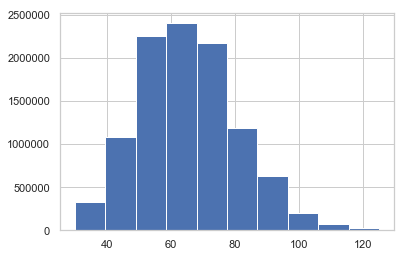

In [28]:
_=plt.hist(df_BP_impute3['DIASTOLIC'])

In [29]:
# 8) sort by index
df_BP_impute3.sort_index(inplace=True)

/anaconda2/envs/bios8366/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [30]:
df_BP_impute3.head()

,RUID,SYSTOLIC,DIASTOLIC,Measure_date
0,50135262,150.0,80.0,01/09/2005
1,50135262,137.0,77.0,02/08/2007
2,50135262,137.0,78.0,02/08/2007
3,50135262,190.0,78.0,02/08/2007
4,50135262,190.0,77.0,02/08/2007


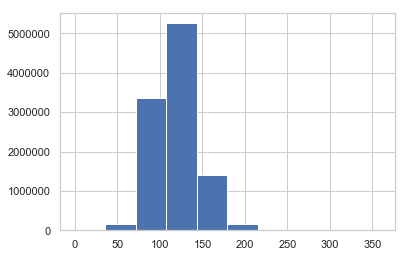

In [31]:
# 9) look at systolic BPs after dropping NaNs
_=plt.hist(df_BP_impute3['SYSTOLIC'])

In [32]:
# 10) impute NaNs by carrying forward SBP and DBP values. first sort 'df_BP_impute2' by index
df_BP_impute4 = df_BP_impute2.copy()

In [38]:
df_BP_impute4.sort_index(inplace=True)

In [39]:
df_BP_impute4.head()

,RUID,SYSTOLIC,DIASTOLIC,Measure_date
0,50135262,150.0,80.0,01/09/2005
1,50135262,137.0,77.0,02/08/2007
2,50135262,137.0,78.0,02/08/2007
3,50135262,190.0,78.0,02/08/2007
4,50135262,190.0,77.0,02/08/2007


In [43]:
# forward fill SYSTOLIC if RUID of row = RUID of previous row
df_BP_impute4['SYSTOLIC'] = df_BP_impute4.groupby(['RUID'])['SYSTOLIC'].ffill()

In [46]:
# check that most SYSTOLIC values have been filled
df_BP_impute4['SYSTOLIC'].isna().sum()

16

In [48]:
# forward fill DIASTOLIC if RUID of row = RUID of previous row
df_BP_impute4['DIASTOLIC'] = df_BP_impute4.groupby(['RUID'])['DIASTOLIC'].ffill()

In [49]:
# check that most DIASTOLIC values have been filled
df_BP_impute4['DIASTOLIC'].isna().sum()

16

In [55]:
# 11) check forward fill was done correctly for df_BP_impute4
df_BP_impute2.head()

,RUID,SYSTOLIC,DIASTOLIC,Measure_date
0,50135262,150.0,80.0,01/09/2005
1,50135262,137.0,77.0,02/08/2007
2,50135262,137.0,78.0,02/08/2007
3,50135262,190.0,78.0,02/08/2007
4,50135262,190.0,77.0,02/08/2007


In [58]:
df_BP_impute2[df_BP_impute2['SYSTOLIC'].isna()].head(15)

,RUID,SYSTOLIC,DIASTOLIC,Measure_date
6148,50135361,NaN,NaN,08/11/2012
6149,50135361,NaN,NaN,08/11/2012
6150,50135361,NaN,NaN,08/11/2012
6152,50135361,NaN,NaN,08/11/2012
6168,50135361,NaN,NaN,08/11/2012
7307,50135361,NaN,NaN,12/18/2007
7317,50135361,NaN,NaN,12/18/2007
7340,50135361,NaN,NaN,12/18/2007
7371,50135361,NaN,NaN,12/18/2007
7373,50135361,NaN,NaN,12/18/2007


In [61]:
df_BP_impute4.iloc[6140:6300,]

,RUID,SYSTOLIC,DIASTOLIC,Measure_date
6140,50135361,39.0,44.0,08/11/2012
6141,50135361,104.0,44.0,08/11/2012
6142,50135361,39.0,56.0,08/11/2012
6143,50135361,104.0,51.0,08/11/2012
6144,50135361,149.0,56.0,08/11/2012
6145,50135361,39.0,54.0,08/11/2012
6146,50135361,105.0,56.0,08/11/2012
6147,50135361,149.0,44.0,08/11/2012
6148,50135361,149.0,44.0,08/11/2012
6149,50135361,149.0,44.0,08/11/2012


looks like forward fill was done correctly

In [62]:
# 12) check to see what rows were not filled in df_BP_impute4
df_BP_impute4[df_BP_impute4['SYSTOLIC'].isna()]

,RUID,SYSTOLIC,DIASTOLIC,Measure_date
279784,53727853,NaN,NaN,01/01/2014
462622,53727997,NaN,NaN,10/13/2009
2199667,53729478,NaN,NaN,04/29/2015
2985046,53730318,NaN,NaN,01/03/2013
3610478,53730803,NaN,NaN,01/07/2013
3610479,53730803,NaN,NaN,03/10/2013
3610480,53730803,NaN,NaN,05/12/2013
4122344,53731233,NaN,NaN,09/24/2005
4533599,53731544,NaN,NaN,01/02/2008
6294418,53732980,NaN,NaN,01/07/2013


In [65]:
df_BP_impute4.loc[df_BP_impute4['RUID']=='53727853'].head()

,RUID,SYSTOLIC,DIASTOLIC,Measure_date
279784,53727853,NaN,NaN,01/01/2014
279785,53727853,91.0,60.0,01/01/2014
279786,53727853,80.0,62.0,01/01/2014
279787,53727853,84.0,62.0,01/01/2014
279788,53727853,77.0,59.0,01/01/2014


In [67]:
# 13) backfill SYSTOLIC NaN values in df_BP_impute4
df_BP_impute4['SYSTOLIC'] = df_BP_impute4.groupby(['RUID'])['SYSTOLIC'].backfill()

In [68]:
# 14) backfill DIASTOLIC NaN values in df_BP_impute4
df_BP_impute4['DIASTOLIC'] = df_BP_impute4.groupby(['RUID'])['DIASTOLIC'].backfill()

In [70]:
# 15) check to see taht backfill was done correctly
df_BP_impute4.loc[df_BP_impute4['RUID']=='53727853'].head()

,RUID,SYSTOLIC,DIASTOLIC,Measure_date
279784,53727853,91.0,60.0,01/01/2014
279785,53727853,91.0,60.0,01/01/2014
279786,53727853,80.0,62.0,01/01/2014
279787,53727853,84.0,62.0,01/01/2014
279788,53727853,77.0,59.0,01/01/2014


In [72]:
# 16) check remaining NaN
df_BP_impute4.loc[df_BP_impute4['SYSTOLIC'].isna()]

,RUID,SYSTOLIC,DIASTOLIC,Measure_date
462622,53727997,NaN,NaN,10/13/2009


In [74]:
# 17) fill remaining NaN with median
df_BP_impute4['SYSTOLIC'].fillna((df_BP_impute4['SYSTOLIC'].median()), inplace=True)
df_BP_impute4['DIASTOLIC'].fillna((df_BP_impute4['DIASTOLIC'].median()), inplace=True)

In [75]:
df_BP_impute4.loc[df_BP_impute4['RUID']=='53727997']

,RUID,SYSTOLIC,DIASTOLIC,Measure_date
462622,53727997,117.0,64.0,10/13/2009


**Aim #1: add median SBP and DBP values to 'labs_median' dataframe**

In [79]:
# 1) first convert columns names to all lowercase in df_BP_impute4
df_BP_impute4.columns = ['ruid','systolic','diastolic','measure_date']

In [80]:
df_BP_impute4.head()

,ruid,systolic,diastolic,measure_date
0,50135262,150.0,80.0,01/09/2005
1,50135262,137.0,77.0,02/08/2007
2,50135262,137.0,78.0,02/08/2007
3,50135262,190.0,78.0,02/08/2007
4,50135262,190.0,77.0,02/08/2007


In [83]:
# 2) create copy of labs_merged dataframe for merging. change lab_date column name to measure_date
labs_merged1 = labs_merged.copy()
labs_merged1.columns = ['ruid','visit_id','hospital_day','lab_name','measure_date','lab_value']

In [84]:
labs_merged1.head()

,ruid,visit_id,hospital_day,lab_name,measure_date,lab_value
0,50135262,0,2007-02-08,PCV,2007-02-08,40.0
1,50135262,0,2007-02-08,K,2007-02-08,4.4
2,50135262,0,2007-02-08,Plt-Ct,2007-02-08,334.0
3,50135262,0,2007-02-08,CO2,2007-02-08,26.0
4,50135262,0,2007-02-08,GluBed,2007-02-08,248.0


# 11.22.18

continue from `11.21.18`

In [99]:
# 1) create groupby dataframe for merging
labs_merged2 = labs_merged1[['ruid','visit_id','measure_date']].drop_duplicates().reset_index(drop=True)

In [100]:
labs_merged2.head()

,ruid,visit_id,measure_date
0,50135262,0,2007-02-08
1,50135262,0,2007-02-09
2,50135262,0,2007-02-10
3,50135262,0,2007-02-11
4,50135262,0,2007-02-12


In [117]:
df_BP_impute4['measure_date'] = pd.to_datetime(df_BP_impute4['measure_date'], errors='coerce')

In [122]:
# 2) merge SBP and DBP to labs_merged2 dataframe
labs_merged3 = pd.merge(labs_merged2,df_BP_impute4,how='left',on=['ruid','measure_date'])

In [123]:
labs_merged3.head()

,ruid,visit_id,measure_date,systolic,diastolic
0,50135262,0,2007-02-08,137.0,77.0
1,50135262,0,2007-02-08,137.0,78.0
2,50135262,0,2007-02-08,190.0,78.0
3,50135262,0,2007-02-08,190.0,77.0
4,50135262,0,2007-02-08,137.0,64.0


In [404]:
labs_merged3[labs_merged3['systolic'].isna()]

,ruid,visit_id,measure_date,systolic,diastolic
562,50135262,3,2008-02-24,NaN,NaN
6097,50135361,0,NaT,NaN,NaN
6185,50135361,4,2008-11-04,NaN,NaN
6315,50135361,5,2008-12-02,NaN,NaN
6700,50135361,6,NaT,NaN,NaN
6757,50135361,7,2009-03-29,NaN,NaN
8658,50135369,0,2004-11-24,NaN,NaN
8659,50135369,0,2004-11-25,NaN,NaN
8660,50135369,0,NaT,NaN,NaN
8661,50135369,0,2004-11-27,NaN,NaN


In [393]:
labs_merged3.isna().sum()

ruid                0
visit_id            0
measure_date     8868
systolic        19007
diastolic       19007
dtype: int64

In [396]:
# impute ffill missing systolic and diastolic values if RUID of row = RUID of previous row
labs_merged3_1 = labs_merged3.copy()
labs_merged3_1 = labs_merged3_1.groupby(['ruid']).ffill()

In [397]:
labs_merged3_1.isna().sum()

ruid               0
visit_id           0
measure_date    1721
systolic        9401
diastolic       9401
dtype: int64

In [398]:
# impute backfill missing systolic and diastolic values if RUID of row = RUID of previous row
labs_merged3_1 = labs_merged3_1.groupby(['ruid']).backfill()

In [399]:
labs_merged3_1.isna().sum()

ruid               0
visit_id           0
measure_date     573
systolic        2687
diastolic       2687
dtype: int64

In [ ]:
# impute rest of NaN values with median values 
labs_merged3_1.fillna((labs_merged3_1.median()), inplace=True)

In [401]:
labs_merged3_1.isna().sum()

ruid              0
visit_id          0
measure_date    573
systolic          0
diastolic         0
dtype: int64

In [403]:
labs_merged3_1.head(10)

,ruid,visit_id,measure_date,systolic,diastolic
0,50135262,0,2007-02-08,137.0,77.0
1,50135262,0,2007-02-08,137.0,78.0
2,50135262,0,2007-02-08,190.0,78.0
3,50135262,0,2007-02-08,190.0,77.0
4,50135262,0,2007-02-08,137.0,64.0
5,50135262,0,2007-02-08,186.0,78.0
6,50135262,0,2007-02-08,186.0,64.0
7,50135262,0,2007-02-08,190.0,64.0
8,50135262,0,2007-02-08,186.0,77.0
9,50135262,0,2007-02-09,160.0,72.0


In [407]:
labs_merged3_1.iloc[[562,]]

,ruid,visit_id,measure_date,systolic,diastolic
562,50135262,3,2008-02-24,118.0,54.0


In [408]:
# 3) get median values for SBP and DBP, grouped by 'ruid' and 'visit_id', in wide format
bp_median = labs_merged3_1.groupby(['ruid','visit_id'])[['systolic','diastolic']].median().reset_index()

In [409]:
bp_median.isna().sum()

ruid         0
visit_id     0
systolic     0
diastolic    0
dtype: int64

In [410]:
bp_median.head()

,ruid,visit_id,systolic,diastolic
0,50135262,0,140.0,58.0
1,50135262,1,121.0,61.0
2,50135262,2,131.0,60.0
3,50135262,3,151.0,74.0
4,50135262,4,134.0,66.0


In [411]:
bp_median.to_csv('bp_median_112218.csv')

In [412]:
bp_median.isna().sum()

ruid         0
visit_id     0
systolic     0
diastolic    0
dtype: int64

# 11.23.18

continue from `11.22.18`

In [413]:
# 4) add median systolic and diastolic values to "labs_median" dataframe
bp_median1 = pd.merge(labs_median2,bp_median,how='left',on=['ruid','visit_id'])

In [414]:
bp_median1.head()

,ruid,visit_id,bun,co2,cl,creat,glubed,gluc,k,na,pcv,plt-ct,systolic,diastolic
0,50135262,0,17.0,26.0,101.0,0.540,137.0,138.0,4.40,136.0,32.0,334.0,140.0,58.0
1,50135262,1,14.0,29.5,99.0,0.715,184.5,213.5,4.45,135.0,39.0,291.5,121.0,61.0
2,50135262,2,11.0,31.0,101.0,0.610,224.5,266.0,3.90,139.0,38.0,308.0,131.0,60.0
3,50135262,3,12.0,29.0,102.0,0.850,205.0,230.0,4.00,135.0,38.0,274.0,151.0,74.0
4,50135262,4,12.5,32.0,100.5,0.750,228.5,162.0,4.10,139.0,36.0,330.0,134.0,66.0


In [415]:
bp_median1.isna().sum()

ruid         0
visit_id     0
bun          0
co2          0
cl           0
creat        0
glubed       0
gluc         0
k            0
na           0
pcv          0
plt-ct       0
systolic     0
diastolic    0
dtype: int64

In [416]:
bp_median1.to_csv('bp_labs_median_112318.csv')

**Aim #1: add median BMI for visit to "bp_median1" dataframe**

In [155]:
# 1) import raw BMI data
df_BMI = pd.read_csv('./Data/FONNESBECK_BMI_20151202.csv',sep=',',dtype={'RUID': str}, infer_datetime_format=True,parse_dates=['Date_BMI'])
df_BMI.head()

,RUID,BMI,Date_BMI,BMI_Weight,BMI_Height,Pregnancy_Indicator
0,50135262,41.43,01/09/2005,119.98,170.18,0
1,50135262,22.86,02/11/2011,70.00,175.00,0
2,50135262,43.07,02/12/2011,131.90,175.00,0
3,50135262,43.06,02/12/2011,131.86,175.00,0
4,50135262,41.47,02/12/2011,127.00,175.00,0


In [156]:
df_BMI['Date_BMI'] = pd.to_datetime(df_BMI['Date_BMI'], errors='coerce')

In [158]:
# 2) convert column names to lower case letters
df_BMI1 = df_BMI.copy()

In [165]:
df_BMI1.columns = [item.lower() for item in df_BMI1.columns]

In [166]:
# 3) clean BMI dataset with imputation forward fill
df_BMI1.isna().sum()

ruid                     0
bmi                    307
date_bmi                 9
bmi_weight             307
bmi_height               0
pregnancy_indicator      0
dtype: int64

In [168]:
# forward fill bmi if RUID of row = RUID of previous row
df_BMI1['bmi'] = df_BMI1.groupby(['ruid'])['bmi'].ffill()

In [170]:
# forward fill date_bmi if RUID of row = RUID of previous row
df_BMI1['date_bmi'] = df_BMI1.groupby(['ruid'])['date_bmi'].ffill()

In [171]:
df_BMI1.isna().sum()

ruid                     0
bmi                      6
date_bmi                 0
bmi_weight             307
bmi_height               0
pregnancy_indicator      0
dtype: int64

In [175]:
# back fill bmi if RUID of row = RUID of previous row
df_BMI1['bmi'] = df_BMI1.groupby(['ruid'])['bmi'].backfill()

In [176]:
# back fill date_bmi if RUID of row = RUID of previous row
df_BMI1['date_bmi'] = df_BMI1.groupby(['ruid'])['date_bmi'].backfill()

In [177]:
df_BMI1.head()

,ruid,bmi,date_bmi,bmi_weight,bmi_height,pregnancy_indicator
0,50135262,41.43,2005-01-09,119.98,170.18,0
1,50135262,22.86,2011-02-11,70.00,175.00,0
2,50135262,43.07,2011-02-12,131.90,175.00,0
3,50135262,43.06,2011-02-12,131.86,175.00,0
4,50135262,41.47,2011-02-12,127.00,175.00,0


In [178]:
df_BMI1.isna().sum()

ruid                     0
bmi                      0
date_bmi                 0
bmi_weight             307
bmi_height               0
pregnancy_indicator      0
dtype: int64

In [192]:
labs_merged2.head()

,ruid,visit_id,measure_date
0,50135262,0,2007-02-08
1,50135262,0,2007-02-09
2,50135262,0,2007-02-10
3,50135262,0,2007-02-11
4,50135262,0,2007-02-12


In [193]:
# 3) merge BMI to labs_merged2 dataframe
df_BMI2 = pd.merge(labs_merged2,df_BMI1,how='left',left_on=['ruid','measure_date'], right_on=['ruid','date_bmi'])

In [206]:
df_BMI2.head(10)

,ruid,visit_id,measure_date,bmi,date_bmi,bmi_weight,bmi_height,pregnancy_indicator
0,50135262,0,2007-02-08,NaN,NaT,NaN,NaN,NaN
1,50135262,0,2007-02-09,NaN,NaT,NaN,NaN,NaN
2,50135262,0,2007-02-10,NaN,NaT,NaN,NaN,NaN
3,50135262,0,2007-02-11,NaN,NaT,NaN,NaN,NaN
4,50135262,0,2007-02-12,NaN,NaT,NaN,NaN,NaN
5,50135262,1,2007-08-03,44.71,2007-08-03,129.5,170.18,0.0
6,50135262,1,2007-08-04,44.78,2007-08-04,129.7,170.18,0.0
7,50135262,1,2007-08-05,45.61,2007-08-05,132.1,170.18,0.0
8,50135262,1,2007-08-06,45.27,2007-08-06,131.1,170.18,0.0
9,50135262,2,2007-08-28,34.53,2007-08-28,100.0,170.18,0.0


In [237]:
# 4) check descriptive statistics after dropping NaN values
df_BMI3 = df_BMI2[~df_BMI2['bmi'].isna()]

In [238]:
df_BMI3['bmi'].describe()

count    51176.000000
mean        29.365929
std          8.156719
min         10.010000
25%         23.620000
50%         28.020000
75%         33.520000
max         69.990000
Name: bmi, dtype: float64

In [239]:
# 5) change bmi to NaN if >70 or <10
df_BMI2['bmi'][(df_BMI2['bmi']>70) | (df_BMI2['bmi']<10)] = np.nan

/anaconda2/envs/bios8366/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [240]:
# 6) fill forward bmi values if RUID of row = RUID of previous row
df_BMI4 = df_BMI2.copy()
df_BMI4['bmi'] = df_BMI4.groupby(['ruid'])['bmi'].ffill()

In [241]:
df_BMI4.head()

,ruid,visit_id,measure_date,bmi,date_bmi,bmi_weight,bmi_height,pregnancy_indicator
0,50135262,0,2007-02-08,NaN,NaT,NaN,NaN,NaN
1,50135262,0,2007-02-09,NaN,NaT,NaN,NaN,NaN
2,50135262,0,2007-02-10,NaN,NaT,NaN,NaN,NaN
3,50135262,0,2007-02-11,NaN,NaT,NaN,NaN,NaN
4,50135262,0,2007-02-12,NaN,NaT,NaN,NaN,NaN


In [242]:
# 7) backfill forward bmi values if RUID of row = RUID of previous row
df_BMI4['bmi'] = df_BMI4.groupby(['ruid'])['bmi'].backfill()

In [243]:
df_BMI4.head()

,ruid,visit_id,measure_date,bmi,date_bmi,bmi_weight,bmi_height,pregnancy_indicator
0,50135262,0,2007-02-08,44.71,NaT,NaN,NaN,NaN
1,50135262,0,2007-02-09,44.71,NaT,NaN,NaN,NaN
2,50135262,0,2007-02-10,44.71,NaT,NaN,NaN,NaN
3,50135262,0,2007-02-11,44.71,NaT,NaN,NaN,NaN
4,50135262,0,2007-02-12,44.71,NaT,NaN,NaN,NaN


In [244]:
# 8) forward fill pregnancy_indicator values if RUID of row = RUID of previous row
df_BMI4['pregnancy_indicator'] = df_BMI4.groupby(['ruid'])['pregnancy_indicator'].ffill()

In [245]:
df_BMI4.head()

,ruid,visit_id,measure_date,bmi,date_bmi,bmi_weight,bmi_height,pregnancy_indicator
0,50135262,0,2007-02-08,44.71,NaT,NaN,NaN,NaN
1,50135262,0,2007-02-09,44.71,NaT,NaN,NaN,NaN
2,50135262,0,2007-02-10,44.71,NaT,NaN,NaN,NaN
3,50135262,0,2007-02-11,44.71,NaT,NaN,NaN,NaN
4,50135262,0,2007-02-12,44.71,NaT,NaN,NaN,NaN


In [247]:
# 9) back fill pregnancy_indicator values if RUID of row = RUID of previous row
df_BMI4['pregnancy_indicator'] = df_BMI4.groupby(['ruid'])['pregnancy_indicator'].backfill()

In [248]:
df_BMI4.head()

,ruid,visit_id,measure_date,bmi,date_bmi,bmi_weight,bmi_height,pregnancy_indicator
0,50135262,0,2007-02-08,44.71,NaT,NaN,NaN,0.0
1,50135262,0,2007-02-09,44.71,NaT,NaN,NaN,0.0
2,50135262,0,2007-02-10,44.71,NaT,NaN,NaN,0.0
3,50135262,0,2007-02-11,44.71,NaT,NaN,NaN,0.0
4,50135262,0,2007-02-12,44.71,NaT,NaN,NaN,0.0


In [249]:
df_BMI4['bmi'].describe()

count    115812.000000
mean         28.944066
std           8.406371
min          10.010000
25%          23.030000
50%          27.510000
75%          33.050000
max          69.990000
Name: bmi, dtype: float64

In [250]:
df_BMI4.isna().sum()

ruid                       0
visit_id                   0
measure_date            8868
bmi                    11403
date_bmi               75474
bmi_weight             75672
bmi_height             75474
pregnancy_indicator    11196
dtype: int64

In [254]:
# 10) fill remaining BMI values with median BMI
df_BMI4['bmi'].fillna(df_BMI4['bmi'].median(), inplace=True)

In [255]:
df_BMI4.head()

,ruid,visit_id,measure_date,bmi,date_bmi,bmi_weight,bmi_height,pregnancy_indicator
0,50135262,0,2007-02-08,44.71,NaT,NaN,NaN,0.0
1,50135262,0,2007-02-09,44.71,NaT,NaN,NaN,0.0
2,50135262,0,2007-02-10,44.71,NaT,NaN,NaN,0.0
3,50135262,0,2007-02-11,44.71,NaT,NaN,NaN,0.0
4,50135262,0,2007-02-12,44.71,NaT,NaN,NaN,0.0


In [256]:
df_BMI4.isna().sum()

ruid                       0
visit_id                   0
measure_date            8868
bmi                        0
date_bmi               75474
bmi_weight             75672
bmi_height             75474
pregnancy_indicator    11196
dtype: int64

In [257]:
# 11) impute '0' remaining NaN for "pregnancy_indicator"
df_BMI4['pregnancy_indicator'].fillna(0, inplace=True)

In [258]:
df_BMI4.isna().sum()

ruid                       0
visit_id                   0
measure_date            8868
bmi                        0
date_bmi               75474
bmi_weight             75672
bmi_height             75474
pregnancy_indicator        0
dtype: int64

In [259]:
df_BMI4.head()

,ruid,visit_id,measure_date,bmi,date_bmi,bmi_weight,bmi_height,pregnancy_indicator
0,50135262,0,2007-02-08,44.71,NaT,NaN,NaN,0.0
1,50135262,0,2007-02-09,44.71,NaT,NaN,NaN,0.0
2,50135262,0,2007-02-10,44.71,NaT,NaN,NaN,0.0
3,50135262,0,2007-02-11,44.71,NaT,NaN,NaN,0.0
4,50135262,0,2007-02-12,44.71,NaT,NaN,NaN,0.0


In [274]:
# 12) pivot df_BMI4 to wide format with median bmi for each visit
df_BMI5 = df_BMI4.groupby(['ruid','visit_id'])[['bmi','pregnancy_indicator']].median().reset_index()

In [275]:
df_BMI5.head()

,ruid,visit_id,bmi,pregnancy_indicator
0,50135262,0,44.710,0.0
1,50135262,1,45.025,0.0
2,50135262,2,46.230,0.0
3,50135262,3,47.140,0.0
4,50135262,4,47.360,0.0


In [260]:
# 13) add median BMI and pregnancy_indicator to bp_median1 dataframe
bp_median1.head()

,ruid,visit_id,BUN,CO2,Cl,Creat,GluBed,Gluc,K,Na,PCV,Plt-Ct,systolic,diastolic
0,50135262,0,17.0,26.0,101.0,0.540,137.0,138.0,4.40,136.0,32.0,334.0,140.0,58.0
1,50135262,1,14.0,29.5,99.0,0.715,184.5,213.5,4.45,135.0,39.0,291.5,121.0,61.0
2,50135262,2,11.0,31.0,101.0,0.610,224.5,266.0,3.90,139.0,38.0,308.0,131.0,60.0
3,50135262,3,12.0,29.0,102.0,0.850,205.0,230.0,4.00,135.0,38.0,274.0,151.0,74.0
4,50135262,4,12.5,32.0,100.5,0.750,228.5,162.0,4.10,139.0,36.0,330.0,134.0,66.0


In [420]:
bp_median2 = pd.merge(bp_median1,df_BMI5,how='left',on=['ruid','visit_id']).drop_duplicates()

In [421]:
bp_median2.head()

,ruid,visit_id,bun,co2,cl,creat,glubed,gluc,k,na,pcv,plt-ct,systolic,diastolic,bmi,pregnancy_indicator
0,50135262,0,17.0,26.0,101.0,0.540,137.0,138.0,4.40,136.0,32.0,334.0,140.0,58.0,44.710,0.0
1,50135262,1,14.0,29.5,99.0,0.715,184.5,213.5,4.45,135.0,39.0,291.5,121.0,61.0,45.025,0.0
2,50135262,2,11.0,31.0,101.0,0.610,224.5,266.0,3.90,139.0,38.0,308.0,131.0,60.0,46.230,0.0
3,50135262,3,12.0,29.0,102.0,0.850,205.0,230.0,4.00,135.0,38.0,274.0,151.0,74.0,47.140,0.0
4,50135262,4,12.5,32.0,100.5,0.750,228.5,162.0,4.10,139.0,36.0,330.0,134.0,66.0,47.360,0.0


In [422]:
bp_median2.to_csv('bp_labs_bmi_median_112318.csv')

**Aim #2: add median EGFR for visit to "bp_median2" dataframe**

In [280]:
# 1) import EGFR dataset
df_EGFR = pd.read_csv('./Data/FONNESBECK_EGFR_20151202.csv',sep=',',dtype={'RUID': str},infer_datetime_format=True, parse_dates=['egfr_date'])
df_EGFR.head()

,RUID,EGFR,egfr_date
0,50135262,123.68000,2007-02-08
1,50135262,123.67783,2007-02-08
2,50135262,76.40173,2011-02-11
3,50135262,76.40000,2011-02-11
4,50135262,78.64000,2011-02-12


In [281]:
df_EGFR.dtypes

RUID                 object
EGFR                float64
egfr_date    datetime64[ns]
dtype: object

In [282]:
df_EGFR1 = df_EGFR.copy()
df_EGFR1.columns = [item.lower() for item in df_EGFR1.columns]

In [283]:
df_EGFR1.head()

,ruid,egfr,egfr_date
0,50135262,123.68000,2007-02-08
1,50135262,123.67783,2007-02-08
2,50135262,76.40173,2011-02-11
3,50135262,76.40000,2011-02-11
4,50135262,78.64000,2011-02-12


In [288]:
# 2) convert EGFR to NaN if >180
df_EGFR1['egfr'][(df_EGFR1['egfr']>180)] = np.nan

/anaconda2/envs/bios8366/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [289]:
df_EGFR1.isna().sum()

ruid             0
egfr         40321
egfr_date        0
dtype: int64

In [291]:
# 3) forward fill NaN values for matching ruids
df_EGFR1['egfr'] = df_EGFR1.groupby(['ruid'])['egfr'].ffill()

In [292]:
df_EGFR1.isna().sum()

ruid             0
egfr         12779
egfr_date        0
dtype: int64

In [293]:
# 4) back fill NaN values for matching ruids
df_EGFR1['egfr'] = df_EGFR1.groupby(['ruid'])['egfr'].backfill()

In [294]:
df_EGFR1.isna().sum()

ruid            0
egfr         8683
egfr_date       0
dtype: int64

In [295]:
df_EGFR1['egfr'].describe()

count    314931.000000
mean         82.858882
std          45.634261
min           0.000000
25%          47.260000
50%          78.916240
75%         115.120000
max         180.000000
Name: egfr, dtype: float64

In [296]:
# 5) fill remaining NaN values with median EGFR
df_EGFR1['egfr'].fillna(df_EGFR1['egfr'].median(), inplace=True)

In [424]:
df_EGFR1.isna().sum()

ruid         0
egfr         0
egfr_date    0
dtype: int64

In [425]:
df_EGFR1['egfr'].describe()

count    323614.000000
mean         82.753095
std          45.022390
min           0.000000
25%          48.180660
50%          78.916240
75%         113.750000
max         180.000000
Name: egfr, dtype: float64

In [428]:
# 6) merge EGFR to labs_merged2 dataframe
df_EGFR2 = pd.merge(labs_merged2,df_EGFR1,how='left',left_on=['ruid','measure_date'], right_on=['ruid','egfr_date'])

In [429]:
df_EGFR2.head()

,ruid,visit_id,measure_date,egfr,egfr_date
0,50135262,0,2007-02-08,123.68000,2007-02-08
1,50135262,0,2007-02-08,123.67783,2007-02-08
2,50135262,0,2007-02-09,NaN,NaT
3,50135262,0,2007-02-10,NaN,NaT
4,50135262,0,2007-02-11,NaN,NaT


In [430]:
# 7) fill forward egfr values if RUID of row = RUID of previous row
df_EGFR3 = df_EGFR2.copy()
df_EGFR3['egfr'] = df_EGFR3.groupby(['ruid'])['egfr'].ffill()

In [431]:
df_EGFR3.isna().sum()

ruid                0
visit_id            0
measure_date     8868
egfr            10953
egfr_date       37916
dtype: int64

In [432]:
# 8) back fill egfr values if RUID of row = RUID of previous row
df_EGFR3['egfr'] = df_EGFR3.groupby(['ruid'])['egfr'].backfill()

In [433]:
df_EGFR3.isna().sum()

ruid                0
visit_id            0
measure_date     8868
egfr             9378
egfr_date       37916
dtype: int64

In [434]:
# 9) fill remaining NaN values with median egfr values
df_EGFR3['egfr'].fillna(df_EGFR3['egfr'].median(), inplace=True)

In [435]:
df_EGFR3.isna().sum()

ruid                0
visit_id            0
measure_date     8868
egfr                0
egfr_date       37916
dtype: int64

In [436]:
df_EGFR3['egfr'].describe()

count    179754.000000
mean         80.862133
std          43.509055
min           1.625810
25%          47.340000
50%          78.427090
75%         110.855500
max         179.970740
Name: egfr, dtype: float64

In [437]:
df_EGFR3.head()

,ruid,visit_id,measure_date,egfr,egfr_date
0,50135262,0,2007-02-08,123.68000,2007-02-08
1,50135262,0,2007-02-08,123.67783,2007-02-08
2,50135262,0,2007-02-09,123.67783,NaT
3,50135262,0,2007-02-10,123.67783,NaT
4,50135262,0,2007-02-11,123.67783,NaT


In [438]:
# 10) pivot df_EGFR3 to wide format with median egfr for each visit
df_EGFR4 = df_EGFR3.groupby(['ruid','visit_id'])[['egfr']].median().reset_index()

In [439]:
df_EGFR4.head()

,ruid,visit_id,egfr
0,50135262,0,123.677830
1,50135262,1,89.505000
2,50135262,2,107.450000
3,50135262,3,73.010770
4,50135262,4,84.358415


In [440]:
df_EGFR4.isna().sum()

ruid        0
visit_id    0
egfr        0
dtype: int64

In [441]:
# 11) add median egfr to bp_median2 dataframe
bp_median2.head()

,ruid,visit_id,bun,co2,cl,creat,glubed,gluc,k,na,pcv,plt-ct,systolic,diastolic,bmi,pregnancy_indicator
0,50135262,0,17.0,26.0,101.0,0.540,137.0,138.0,4.40,136.0,32.0,334.0,140.0,58.0,44.710,0.0
1,50135262,1,14.0,29.5,99.0,0.715,184.5,213.5,4.45,135.0,39.0,291.5,121.0,61.0,45.025,0.0
2,50135262,2,11.0,31.0,101.0,0.610,224.5,266.0,3.90,139.0,38.0,308.0,131.0,60.0,46.230,0.0
3,50135262,3,12.0,29.0,102.0,0.850,205.0,230.0,4.00,135.0,38.0,274.0,151.0,74.0,47.140,0.0
4,50135262,4,12.5,32.0,100.5,0.750,228.5,162.0,4.10,139.0,36.0,330.0,134.0,66.0,47.360,0.0


In [442]:
bp_median3 = pd.merge(bp_median2,df_EGFR4,how='left',on=['ruid','visit_id']).drop_duplicates()

In [443]:
bp_median3.head()

,ruid,visit_id,bun,co2,cl,creat,glubed,gluc,k,na,pcv,plt-ct,systolic,diastolic,bmi,pregnancy_indicator,egfr
0,50135262,0,17.0,26.0,101.0,0.540,137.0,138.0,4.40,136.0,32.0,334.0,140.0,58.0,44.710,0.0,123.677830
1,50135262,1,14.0,29.5,99.0,0.715,184.5,213.5,4.45,135.0,39.0,291.5,121.0,61.0,45.025,0.0,89.505000
2,50135262,2,11.0,31.0,101.0,0.610,224.5,266.0,3.90,139.0,38.0,308.0,131.0,60.0,46.230,0.0,107.450000
3,50135262,3,12.0,29.0,102.0,0.850,205.0,230.0,4.00,135.0,38.0,274.0,151.0,74.0,47.140,0.0,73.010770
4,50135262,4,12.5,32.0,100.5,0.750,228.5,162.0,4.10,139.0,36.0,330.0,134.0,66.0,47.360,0.0,84.358415


In [444]:
bp_median3.isna().sum()

ruid                   0
visit_id               0
bun                    0
co2                    0
cl                     0
creat                  0
glubed                 0
gluc                   0
k                      0
na                     0
pcv                    0
plt-ct                 0
systolic               0
diastolic              0
bmi                    0
pregnancy_indicator    0
egfr                   0
dtype: int64

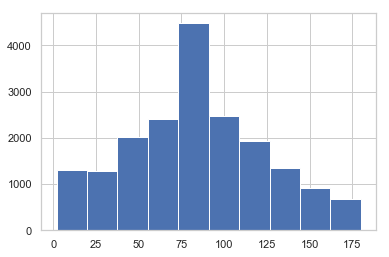

In [446]:
_=plt.hist(bp_median3['egfr'])

**Note:** cleaning and imputation of EGFR may have been overdone, which may affect out model

In [447]:
bp_median3.to_csv('labs_bp_bmi_egfr_table_112418.csv')